<a href="https://colab.research.google.com/github/yingzibu/ODE/blob/main/experiment/PO/one_compartment/Ac_only_1_dim_fail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In reality, we only have Ac data

## And what if we have tlag? (Solved)

In [1]:
! pip install torchdiffeq --quiet
! pip install latex --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [2]:
import os
import argparse
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings

matplotlib.rcParams['figure.figsize'] = (3.5, 3)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
# constant
method_ode = 'dopri5'
data_size = 1000
batch_time = 10
batch_size = 512
niters = 2000
test_freq = 3
viz = True
gpu_num = 0
adjoint = True
fig_path = 'png'
device = torch.device('cuda:'+str(gpu_num) if torch.cuda.is_available() else 'cpu')

\begin{equation*}
    \frac{d}{dt} \begin{bmatrix}
        A_a \\
        A
    \end{bmatrix} = \begin{bmatrix}
        -K_a & 0 \\
        K_a & -K
    \end{bmatrix}
    \begin{bmatrix}
        A_a \\
        A
    \end{bmatrix}, \text{IC (initial condition)}:\begin{bmatrix}
        A_a \\
        A
    \end{bmatrix} = \begin{bmatrix}
        Dose \\
        0
    \end{bmatrix} \text{ at time } = t_{\text{lag}}
\end{equation*}



Then let  
    \begin{equation}
    M = \begin{bmatrix}
        -K_a & 0 \\
        K_a & -K
    \end{bmatrix}
    \end{equation}

## We only have true A, thus we will handle A only, we will ignore Aa since we do not have that data in real life (If we have that, then I will be happy though)

In [71]:
# first order PO related constants
Dose = 2.0 # initial dose for PO
ka = 0.5
k = 0.2
MAX_T = 25
t_lag = 2

true_M = torch.tensor([[-ka, 0.], [ka, -k]]).to(device)
true_y0_all = torch.tensor([[Dose, 0.]]).to(device) # initial conditions for Aa and A
t = torch.linspace(t_lag, MAX_T+t_lag, data_size).to(device) # consider t_lag

# print(true_y0.shape)

true_y0 = true_y0_all[:, -1].reshape(1,1)

# dim = true_y0.shape[-1]

######################################
dim = 1
######################################

For obtaining true_y which is $[A_a, A] \in \mathbb{R}^{1\times 2}$ a row vector, we have the ODE defined above, thus
$y = \text{ODESolver}(\text{ode_func}, y_0, t)$
We already know that by PK definition, the ode_func is defined as $dy/dt = yM^\top$, we would like to see whether NN could approximate the ode_func.

In [109]:
class ODEFunc(nn.Module):
    """
    Aim: use NN to approximate ode_func.
    Input dim should be the same as output dim,
    since dy/dt has the same dim of y

    param dim: int, input dimension
    return
        dy/dt, which is ode_func value at y
    """
    def __init__(self, dim=dim, t_lag=t_lag):
        super(ODEFunc, self).__init__()
        self.t_lag = t_lag
        self.net = nn.Sequential(
            nn.Linear(dim, 32), nn.Tanh(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, dim)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
    def forward(self, t, y):
        # if t < self.t_lag: # dy/dt = [0], no change in either compartment
            # return torch.zeros(y.shape)
        return self.net(y)


class Lambda(nn.Module):
    def forward(self, t, y, t_lag=t_lag): # need transpose M, since y is a row vector
        if t < t_lag: # consider lag time
            return torch.mm(y, torch.zeros([2,2]).to(device))
        return torch.mm(y, true_M.T)


In [87]:
true_y.shape

torch.Size([1000, 1, 1])

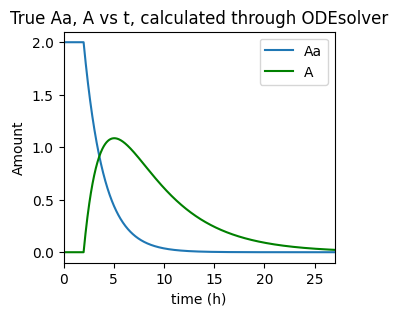

In [88]:
## Considre the Amount before t_lag
t_all = torch.linspace(0., MAX_T+t_lag, data_size).to(device) # consider t_lag
with torch.no_grad():
    true_y_all = odeint(Lambda(), true_y0_all, t_all, method=method_ode)
s0, s1, s2 = true_y_all.shape

true_y = true_y_all[:, :, 1].reshape(s0, s1, 1)
time_ = t_all.cpu().numpy()
true_Aa = true_y_all.cpu().numpy()[:, 0, 0]
true_Ac = true_y_all.cpu().numpy()[:, 0, 1]

fig = plt.figure()
plt.plot(time_, true_Aa, time_, true_Ac, 'g-')
t_max = t.max().cpu().numpy().item()
plt.legend(['Aa', 'A'])
plt.xlim([0., t_max])
plt.xlabel('time (h)')
plt.ylabel('Amount')
plt.title('True Aa, A vs t, calculated through ODEsolver')
plt.show()
plt.close()

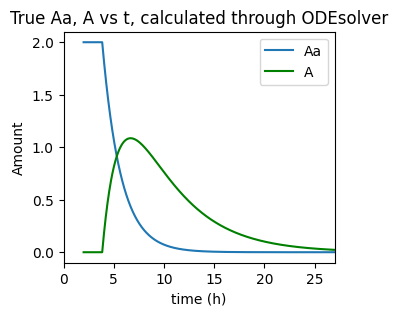

In [89]:
fig = plt.figure()
plt.plot(t.cpu().numpy(), true_y_all.cpu().numpy()[:,0,0],
         t.cpu().numpy(), true_y_all.cpu().numpy()[:,0,1], 'g-')
t_max = t.max().cpu().numpy().item()
plt.legend(['Aa', 'A'])
plt.xlim([0., t_max])
plt.xlabel('time (h)')
plt.ylabel('Amount')
plt.title('True Aa, A vs t, calculated through ODEsolver')
plt.show()
plt.close()

## Explicit function

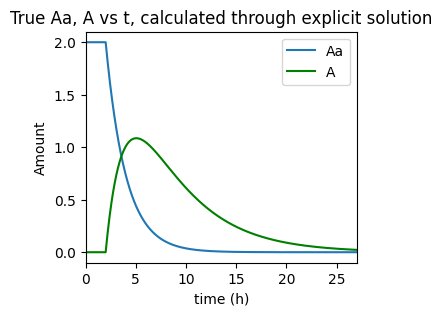

In [90]:
def explicit_solution(t, ka=ka, k=k, D=Dose, t_lag=t_lag):
    v1 = np.array([[k-ka], [ka]])
    v2 = np.array([[0.], [1.]])
    C1 =  D / (k - ka)
    C2 = -ka * C1

    if t < t_lag:
        A = np.array([[D], [0.]])
    else:
        t_here = t - t_lag
        A = C1 * v1 * np.exp(-ka * t_here) + C2 * v2 * np.exp(-k * t_here)
    return A
fig = plt.figure()
true_y_explicit = np.stack(([explicit_solution(t_) for t_ in time_]))

plt.plot(time_, true_y_explicit[:,0,0],
         time_, true_y_explicit[:,1,0], 'g-')
t_max = t.max().cpu().numpy().item()


plt.legend(['Aa', 'A'])
plt.xlim([0., t_max])
plt.xlabel('time (h)')
plt.ylabel('Amount')
plt.title('True Aa, A vs t, calculated through explicit solution')
plt.show()
plt.close()

## IN reality, we only have central compartment data, we do not have the absorption compartment data.

### Then we will only select the central compartment data for training

In [ ]:
############################################################################
## This code does not work
## Masking Aa data will train a biased model, that is bad, not wanted
############################################################################

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time,
                                                    dtype=np.int64),
                         batch_size, replace=False))
    # print(s)
    batch_y0 = true_y[s]
    batch_t = t[:batch_time]
    batch_y = torch.stack([true_y[s+i] for i in range(batch_time)], dim=0)

    # ADD MASK for Aa
    # in reality, we do not have Aa vs time data, except the first time point Aa = D
    mask = torch.zeros_like(batch_y0)
    mask[:, :, 1] = 1 # we only have the AC input
    mask[0, 0, 0] = 1 # we still have the dose input
    mask[-1, 0,0] = 1 # lets have the final data point of Aa, we could use Aa=[0] when t = infty
    batch_y0 *= mask # apply mask, will only show Ac data, and at t=t_lag Aa data


    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [103]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time,
                                                    dtype=np.int64),
                         batch_size, replace=False))
    # print(s)
    batch_y0 = true_y[s]
    batch_t = t[:batch_time]
    batch_y = torch.stack([true_y[s+i] for i in range(batch_time)], dim=0)

    # batch_y0 = batch_y0[:, :, -1].reshape(batch_y0.shape[0],batch_y0.shape[1],1)
    # batch_y = batch_y[:,:,:, -1].reshape(batch_time, batch_size, 1, 1)


    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

def makedirs(dirname):
    if not os.path.exists(dirname): os.makedirs(dirname)

Epoch 0261 | Total Loss 0.363
Epoch 0264 | Total Loss 0.367
Epoch 0267 | Total Loss 0.361


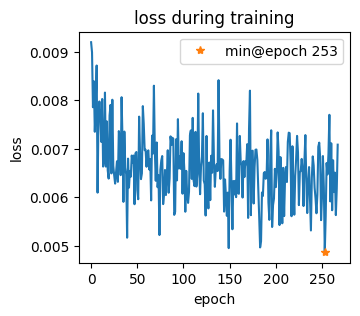

Epoch 0270 | Total Loss 0.362
Epoch 0273 | Total Loss 0.375
Epoch 0276 | Total Loss 0.367


KeyboardInterrupt: 

In [110]:

def visualize_dim_1(true_y, pred_y, odefunc, itr, fig_path=None):
    if fig_path==None: fig_path = 'png'; makedirs(fig_path)
    # fig, (ax_traj, ax_phase, ax_vecfield) = plt.subplots(1, 3, figsize=(12,4))

    fig = plt.figure()
    time_ = t.cpu().numpy()

    plt.plot(time_, true_y.cpu().numpy()[:,0,0])
    plt.plot(time_, pred_y.cpu().numpy()[:,0,0], 'g--')

    t_max = t.max().cpu().numpy().item()


    plt.legend(['True A', 'Pred A'])
    plt.xlim([0., t_max])
    plt.xlabel('time (h)')
    plt.ylabel('Amount')
    # plt.title('True Aa, A vs t, calculated through explicit solution')

    # plt.savefig('png/{:03d}'.format(itr))
    fig.suptitle('Iteration {:03d}'.format(itr))
    fig.tight_layout()
    fig.savefig('png/{:03d}'.format(itr))
    # plt.draw()
    # plt.pause(0.001)
    plt.close(fig)

def visualize_dim_2(true_y, pred_y, odefunc, itr, fig_path=None):
    if fig_path==None: fig_path = 'png'; makedirs(fig_path)
    fig, (ax_traj, ax_phase, ax_vecfield) = plt.subplots(1, 3, figsize=(12,4))

    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('Aa, A')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,0,0],
                 t.cpu().numpy(), true_y.cpu().numpy()[:,0,1], 'g-')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0], '--',
                 t.cpu().numpy(), pred_y.cpu().numpy()[:,0,1], 'b--')
    ax_traj.set_xlim(0., t.cpu().max())
    ax_traj.set_ylim(-0.1, Dose * 1.1) # Since Aa and A cannot exceed [0, Dose]
    ax_traj.legend(['True Aa', 'True A', 'Pred Aa', 'Pred A'])

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('Aa')
    ax_phase.set_ylabel('A')
    ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(-0.1, Dose*1.1) # since Aa cannot exceed [0, Dose]
    ax_phase.set_ylim(-0.1, Dose*1.1) # since A  cannot exceed [0, Dose]
    ax_phase.legend(['True', 'Pred'])

    ax_vecfield.cla()
    ax_vecfield.set_title('Learned Vector Field')
    ax_vecfield.set_xlabel('Aa')
    ax_vecfield.set_ylabel('A')

    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlim(-2, 2)
    ax_vecfield.set_ylim(-2, 2)


    # plt.savefig('png/{:03d}'.format(itr))
    fig.suptitle('Iteration {:03d}'.format(itr))
    fig.tight_layout()
    fig.savefig('png/{:03d}'.format(itr))
    # plt.draw()
    # plt.pause(0.001)
    plt.close(fig)
if dim == 2: visualize = visualize_dim_2
if dim == 1: visualize = visualize_dim_1


ii = 0
func = ODEFunc().to(device)
optimizer = optim.AdamW(func.parameters(), lr=1e-3, weight_decay=1e-4)
# end = time.time()
min_loss = np.inf
min_epoch = 0
loss_all = []
patience = 350
fig_freq = 30
model_path_ = 'test.pt'
mean_df = pd.DataFrame()

for epoch in range(niters):
    func.train()
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)

    # only care about difference in Ac
    loss = torch.mean(torch.abs(pred_y-batch_y))
    loss_all.append(loss.item())
    loss.backward()
    optimizer.step()

    if loss.item() < min_loss: # loss drop, save model
        min_loss = loss.item(); min_epoch = epoch
        torch.save(func.state_dict(), model_path_)

    if epoch - min_epoch > patience:
        print('early stop'); break

    if epoch % test_freq == 0:
        func.eval()
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y-true_y)) # all loss, include Aa
            print('Epoch {:04d} | Total Loss {:.3f}'.format(epoch, loss.item()))
            if viz: visualize(true_y, pred_y, func, ii) # ii is the png figure pass num

            y_nn = func(_, true_y)
            y_nn = y_nn.reshape(y_nn.shape[0], dim).cpu().detach()

            ii += 1


            # Visualize loss during training
            if ii % fig_freq == 0:
                plt.plot(loss_all)
                plt.plot(min_epoch, min_loss, '*',
                         label=f'min@epoch {min_epoch}')
                plt.xlabel('epoch'); plt.ylabel('loss');
                plt.title('loss during training')
                plt.legend(); plt.show(); plt.close()


load model from path:  test.pt


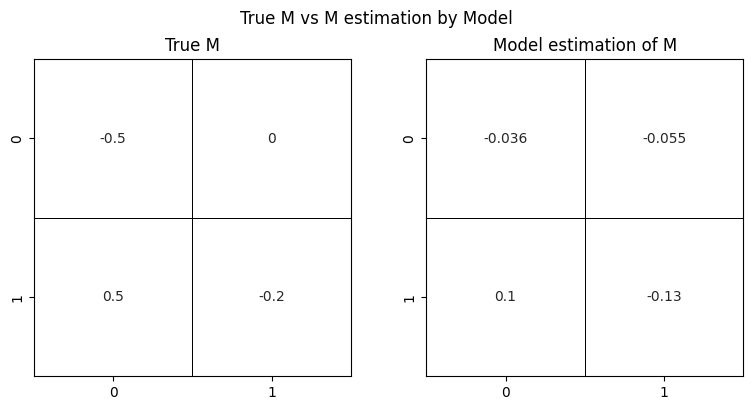

In [38]:
def load_model(model, path, device='cpu'):
    print('load model from path: ', path)
    model.load_state_dict(torch.load(path, map_location=device))

load_model(func, model_path_)

y_nn = func(_, true_y)
y_temp = true_y.reshape(true_y.shape[0], dim).cpu().detach()
M_T = torch.linalg.inv(y_temp.T @ y_temp)
M_T = M_T @ y_temp.T @ (y_nn.reshape(y_nn.shape[0], dim).cpu().detach())

true_M_ = true_M.cpu().detach().numpy()
pred_M_ = M_T.T.numpy()
fig, (ax_true, ax_pred) = plt.subplots(1, 2, figsize=(8,4))

ax_true.cla()

sns.heatmap(true_M_, annot=True, square=True,
            cmap='gray_r', vmin=0, vmax=0,  # set all to white
            linewidths=0.5, linecolor='k',  # draw black grid lines
            cbar=False, ax=ax_true)         # disable colorbar
sns.despine(left=False, right=False, top=False, bottom=False)
ax_true.set_title('True M')

ax_pred.cla()
sns.heatmap(pred_M_, annot=True, square=True,
            cmap='gray_r', vmin=0, vmax=0,  # set all to white
            linewidths=0.5, linecolor='k',  # draw black grid lines
            cbar=False, ax=ax_pred)         # disable colorbar
sns.despine(left=False, right=False, top=False, bottom=False)
ax_pred.set_title('Model estimation of M')

fig.suptitle('True M vs M estimation by Model')
fig.tight_layout(); plt.show(fig); plt.close(fig)

<ipython-input-111-4f1c972f006e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


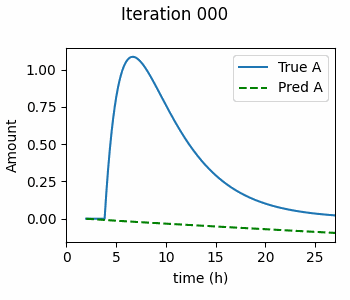

In [111]:
import imageio
images = []
# for filename in filenames:
for i in range(ii):
    filename = '{:03d}.png'.format(i)
    filename = f'{fig_path}/{filename}'
    images.append(imageio.imread(filename))
imageio.mimsave('png/gif.gif', images, fps=3)
from IPython.display import Image
Image('png/gif.gif')

<ipython-input-27-61249cb003fe>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


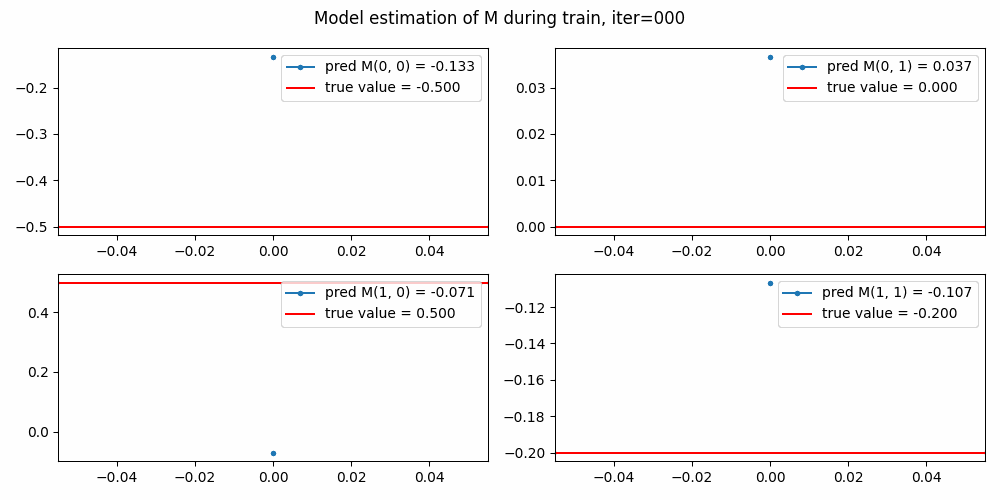

In [27]:
import imageio
images = []
# for filename in filenames:
for i in range(ii):
    filename = '{:03d}.png'.format(i)
    filename = f'M_estimate/{filename}'
    images.append(imageio.imread(filename))
imageio.mimsave('M_estimate/gif_M_estimate.gif', images, fps=3)
from IPython.display import Image
Image('M_estimate/gif_M_estimate.gif')

In [18]:
import torch

# Create a tensor of shape (N, 1, 2)
N = 5  # example size for N
tensor = torch.rand(N, 1, 2)  # you can use any tensor here

# Print the original tensor
print("Original tensor:")
print(tensor)

# Create a mask
# The mask will have the shape (N, 1, 2) and will be all zeros
mask = torch.zeros_like(tensor)

# Set the first element (0, 0, 0) to 1
mask[:, :, 1] = 1
mask[0, 0, 0] = 1

# Apply the mask
masked_tensor = tensor * mask

# Print the masked tensor
print("\nMasked tensor:")
print(masked_tensor)

Original tensor:
tensor([[[0.6979, 0.3606]],

        [[0.1789, 0.6397]],

        [[0.0275, 0.0718]],

        [[0.5148, 0.7533]],

        [[0.3634, 0.2789]]])

Masked tensor:
tensor([[[0.6979, 0.3606]],

        [[0.0000, 0.6397]],

        [[0.0000, 0.0718]],

        [[0.0000, 0.7533]],

        [[0.0000, 0.2789]]])


In [108]:
batch_y

tensor([[[[0.3915]],

         [[0.9104]],

         [[0.1864]],

         ...,

         [[0.4329]],

         [[0.5041]],

         [[0.0000]]],


        [[[0.4107]],

         [[0.9073]],

         [[0.1854]],

         ...,

         [[0.4308]],

         [[0.5017]],

         [[0.0000]]],


        [[[0.4295]],

         [[0.9043]],

         [[0.1844]],

         ...,

         [[0.4287]],

         [[0.4993]],

         [[0.0000]]],


        ...,


        [[[0.5177]],

         [[0.8887]],

         [[0.1796]],

         ...,

         [[0.4181]],

         [[0.4873]],

         [[0.0000]]],


        [[[0.5343]],

         [[0.8855]],

         [[0.1787]],

         ...,

         [[0.4160]],

         [[0.4849]],

         [[0.0000]]],


        [[[0.5505]],

         [[0.8824]],

         [[0.1777]],

         ...,

         [[0.4139]],

         [[0.4825]],

         [[0.0000]]]], device='cuda:0')

In [21]:
mask = torch.zeros_like(a)
mask[:, :, 1] = 1
mask[0, 0, 0] = 1 # we still have the dose input
a * mask

tensor([[[8.6584e-05, 5.9758e-02]],

        [[0.0000e+00, 2.0107e-01]],

        [[0.0000e+00, 1.7965e-01]],

        ...,

        [[0.0000e+00, 2.7555e-02]],

        [[0.0000e+00, 2.7568e-01]],

        [[0.0000e+00, 9.9127e-01]]], device='cuda:0')